In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction
using Optim

include("../Utils/scale_utils.jl")
using .ScaleUtils

include("../Utils/gp_utils.jl")
using .GPUtils

# Access the matplotlib module
matplotlib = pyimport("matplotlib")
seaborn = pyimport("seaborn")
os = pyimport("os")
pyimport("scienceplots")
np = pyimport("numpy")
scipy = pyimport("scipy")
skl_model_selection = pyimport("sklearn.model_selection")
plt.style.use(["default","science","no-latex"])
using StatsPlots

seaborn.color_palette("colorblind")

PyCall.pygui(:tk)

# Set a seed for reproducibility
using Random
Random.seed!(11);

#import Pkg
#Pkg.add("PrettyTables")
SIZE=21
FONTSIZE=20.5
DOTCOLOR="green"
EDGECOLOR="gray"
plt.style.use(["default","science","no-latex"])

In [2]:
matplotlib_backends_pdf = pyimport("matplotlib.backends.backend_pdf")
PdfPages = matplotlib_backends_pdf.PdfPages

PyObject <class 'matplotlib.backends.backend_pdf.PdfPages'>

In [3]:
function unscale_params(params)
    
    unscaled_θ_1 = ( params[1] * (X_maxs[:vmThresh] - X_mins[:vmThresh]) ) + X_mins[:vmThresh]
    unscaled_θ_2 = ( params[2] * (X_maxs[:fricExp] - X_mins[:fricExp]) ) + X_mins[:fricExp]
    unscaled_θ_3 = ( params[3] * (X_maxs[:mu_scale] - X_mins[:mu_scale]) ) + X_mins[:mu_scale]
    unscaled_θ_4 = ( params[4] * (X_maxs[:stiff_scale] - X_mins[:stiff_scale]) ) + X_mins[:stiff_scale]
    unscaled_θ_5 = ( params[5] * (X_maxs[:gamma0] - X_mins[:gamma0]) ) + X_mins[:gamma0]
    unscaled_θ_6 = ( params[6] * (X_maxs[:melt_flux] - X_mins[:melt_flux]) ) + X_mins[:melt_flux];
    unscaled_thetas = [unscaled_θ_1
                        unscaled_θ_2
                        unscaled_θ_3
                        unscaled_θ_4
                        unscaled_θ_5
                        unscaled_θ_6];
    return unscaled_thetas
    
end

unscale_params (generic function with 1 method)

In [4]:
#All years from 2016 - 2300
all_years_no_gap = collect(range(2016, step=1, length=285))
yrs_gapped = collect(range(2030, step=15, length=19));

# Mapping those years to indices in a list
yrs_dict = Dict{Int64, Int64}()
for (idx,yr) in enumerate(all_years_no_gap)
        yrs_dict[yr] = idx
end


In [5]:
#Loading original parameter data for scaling purposes
X_raw = CSV.read("../Data/Training_Data/Amery_Input_Parameters_Filtered.csv", DataFrame);
# 1) Grab all column‐names as Symbols
cols = Symbol.(names(X_raw))
# 2) Remove the index‐column symbol
cols = filter(c -> c != :Column1, cols)
# 3) Now call get_scaled_matrix on the remaining columns
X_scaled_t, X_scalers, X_mins, X_maxs = ScaleUtils.get_scaled_matrix(X_raw, cols);

function tuple_to_idx(x,y)
    return ( (3*x - 3) + y )
end

tuple_to_idx (generic function with 1 method)

In [6]:
#Returns means, upper, and lower quntailes for a single year's prediction from a single (trajectory, yr_calibrated) pair
function calculate_quantiles_mean(sample, row)
    slice = sample[row, :]
    mean_data = mean(slice)
    quantile_5 = quantile(slice, 0.05)
    quantile_95 = quantile(slice, 0.95)
    
    return mean_data, quantile_5, quantile_95

end

calculate_quantiles_mean (generic function with 1 method)

In [7]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
                                        # Plot for main body of paper 
##################################################################################################################
##################################################################################################################
##################################################################################################################

In [8]:
# Choose desired year of projections as well as calibration year
projection_year =  2300
calibration_year = 2300
# Corresponding row index in the projection matrix
row_idx = yrs_dict[projection_year]
Realizations = [string(i) for i in 1:100]

# --- Set necessary paths ---
# Where your generative parameters are
future_obs_directory = "../Data/Future_Observation_Data/Generative_Parameters/Official_Constraining_Observations-metadata"
# Where you want the plot saved to
output_file_name   = "../Plots/Sensitivity_Plots/SLR_sensitivity_proj$(projection_year)_cal_$(calibration_year).pdf"
# Where your projection data is
SLR_projections_path = "../Data/Projection_Data"


# --- collect widths for all realizations ---
widths = Array{Float64}(undef, length(Realizations))
θ_mat  = Array{Float64}(undef, length(Realizations), 6)

# Calculate 90% credible interval widths 
for (i, r) in enumerate(Realizations)
    vaf_sample = JLD2.load("$(SLR_projections_path)/R_$(r)/$(r)-year$(calibration_year)pred_VAF.jld2",
                           "sample_post_mm_ssp5")
    
    # Calculate the upper and lower quantiles
    μ, lower, upper = calculate_quantiles_mean(vaf_sample, row_idx)

    # Calculate credible interval width
    widths_all_years = upper .- lower      
    widths[i] = widths_all_years[end]          

    # Load and unscale this trajectories generative parameters
    θ = JLD2.load(joinpath(future_obs_directory, "$(r)_emulator_data.jld2"), "θ")
    θ_mat[i, :] = unscale_params(θ)            # ensure this returns a 6-vector
end

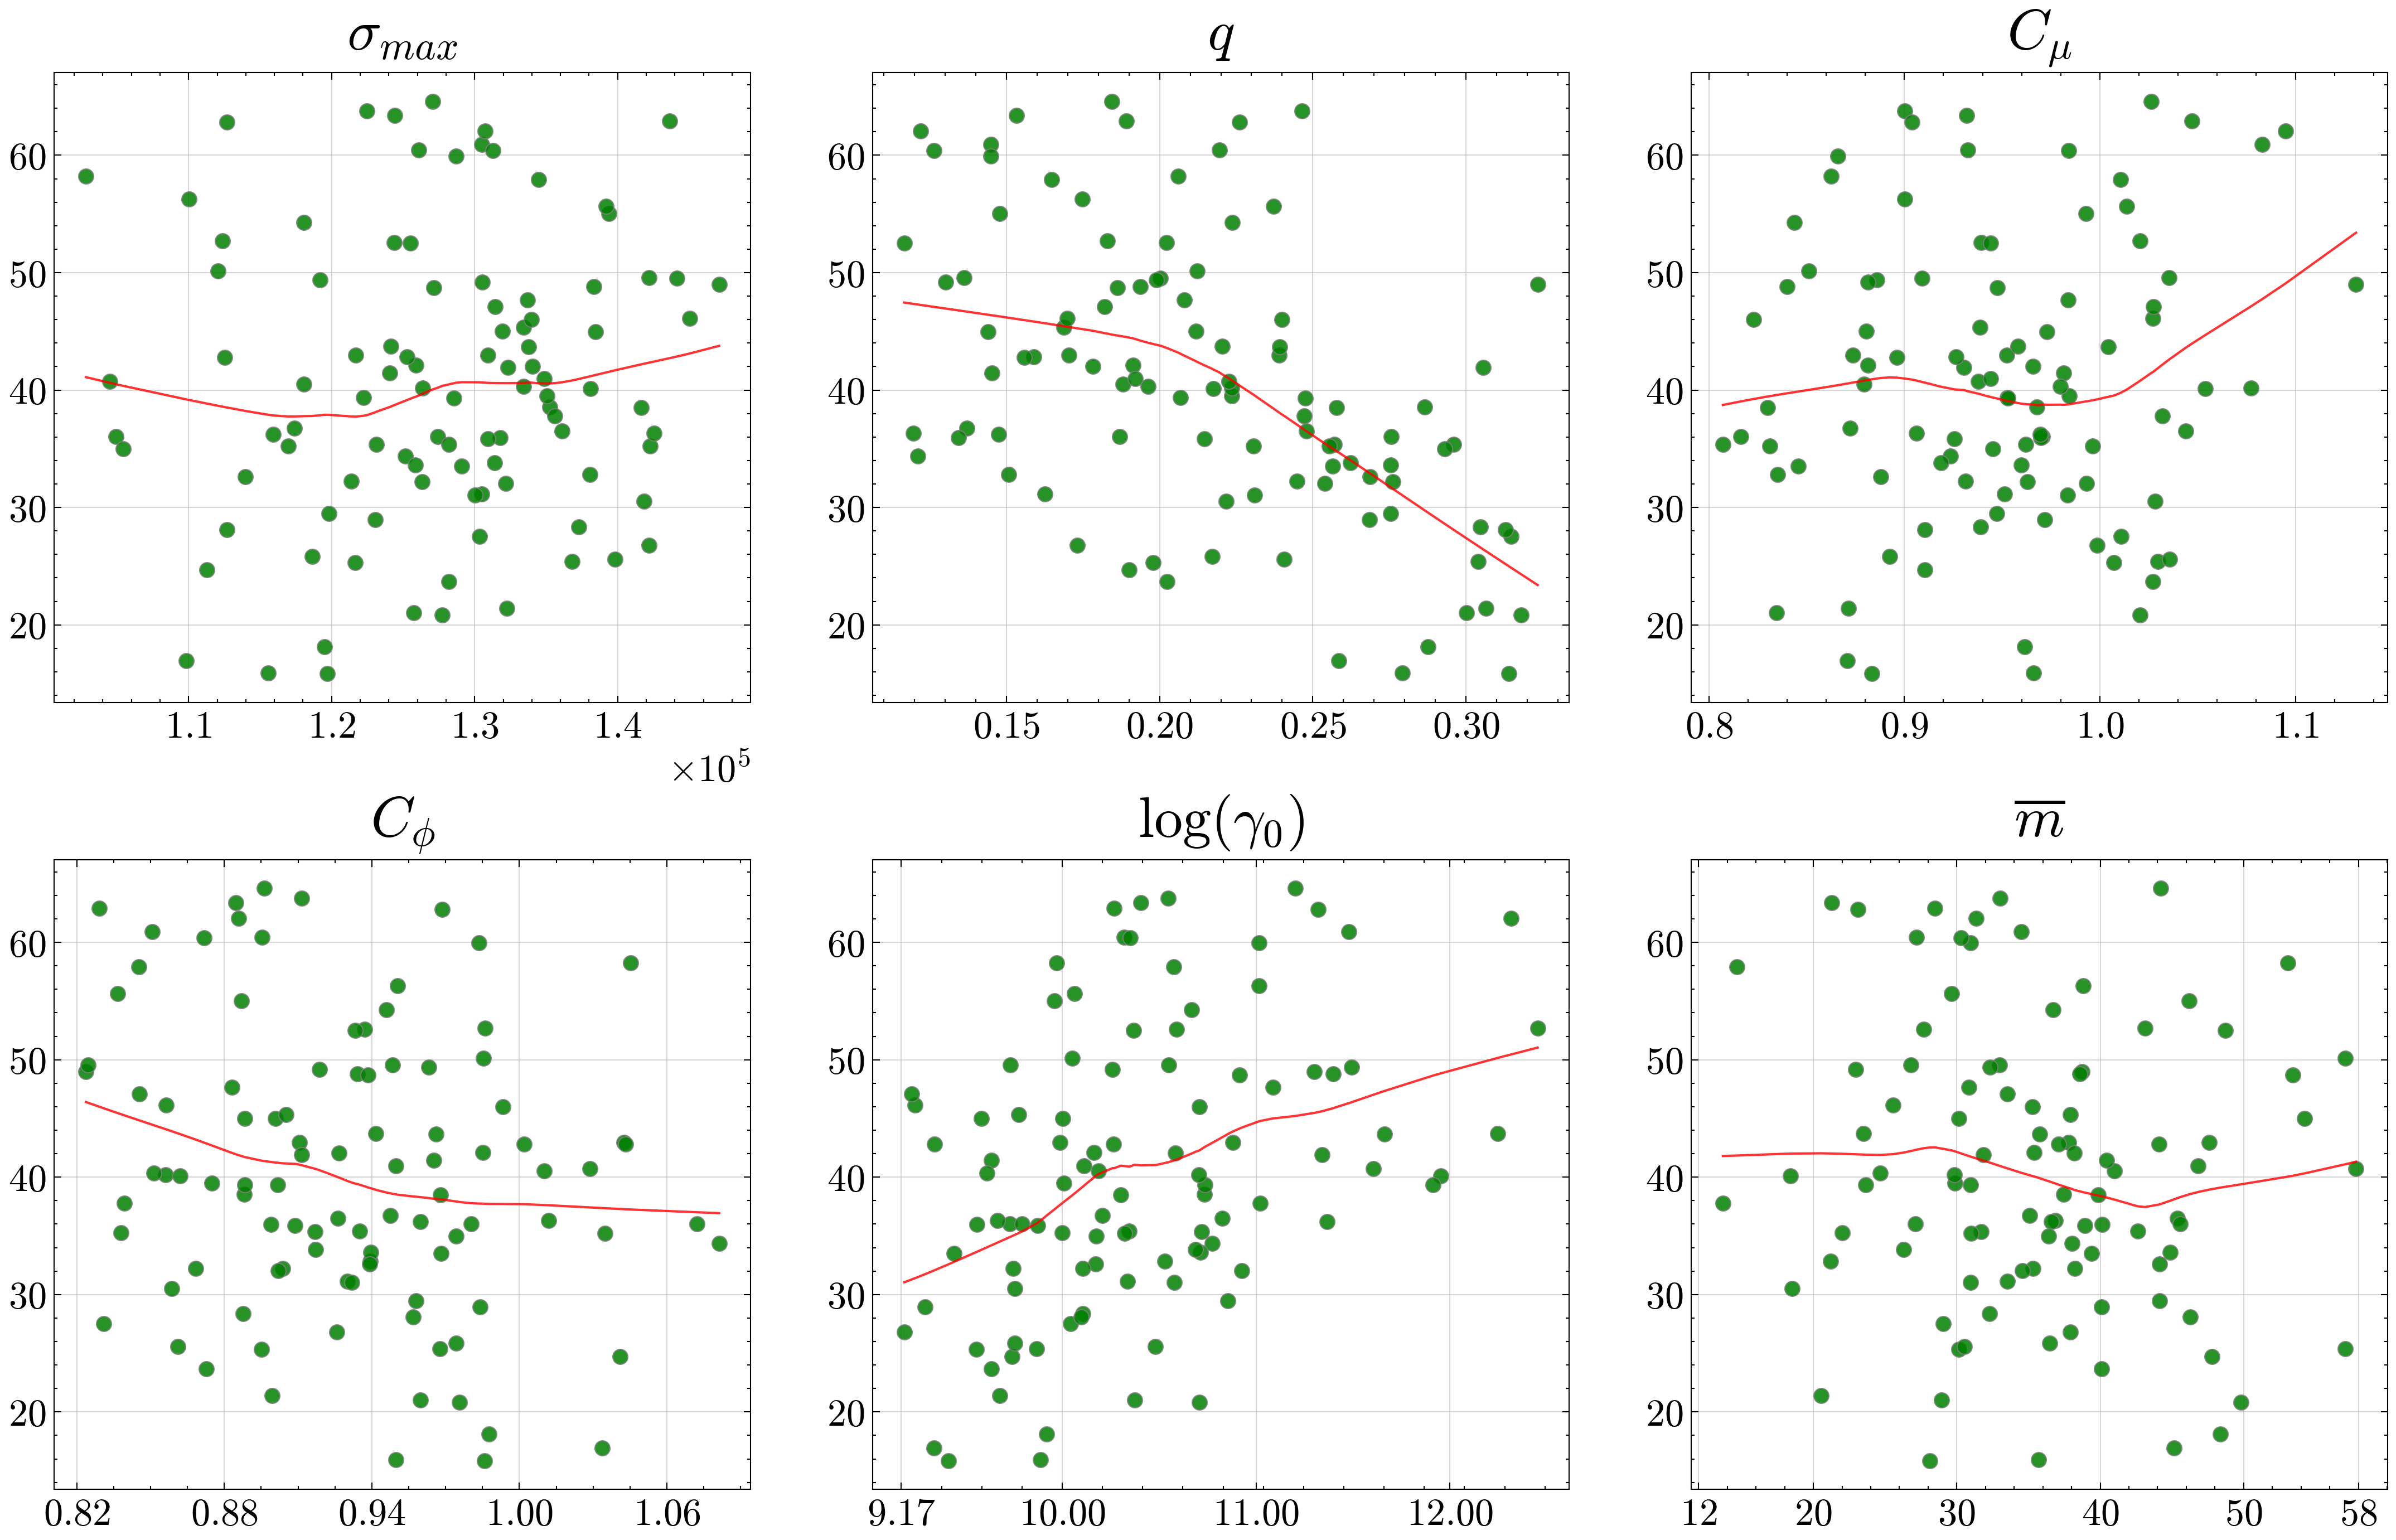

In [10]:
# --- plotting: 2×3 grid, one subplot per parameter ---
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(18, 11), dpi=300,
    gridspec_kw=Dict("height_ratios"=>[1,1], "width_ratios"=>[1,1,1], "wspace"=>0.175, "hspace"=>0.25))

FONTSIZE=20.5
# fig.suptitle("Sea-level Contributions 90% Credible Interval Widths at $(chosen_year)"; fontsize=30, fontweight="bold", y=0.98)

title_dict = Dict(1=>L"\sigma_{max}", 2=>L"q", 3=>L"C_{\mu}", 4=>L"C_{\phi}", 5=>L"\log(\gamma_0)", 6=>L"\overline{m}")
tick_dict  = Dict(1=>[1.1e5,1.2e5,1.3e5,1.4e5],
                  2=>[0.15,0.2,0.25,0.3],
                  3=>[0.8,0.9,1,1.1],
                  4=>[0.82,0.88,0.94,1,1.06],
                  5=>[9.17,10,11,12],
                  6=>[12,20,30,40,50,58])

xlim_dict = Dict([1 => [1.02e5,1.485e5], 
                  2 => [0.108,0.333], 
                  3 => [0.78,1.148],
                  4 => [0.81,1.095], 
                  5 => [9.05,12.6], 
                  6 => [10,60]])

for j in 1:6
    rI = (j-1) ÷ 3 + 1
    cI = (j-1) % 3 + 1
    axi = ax[rI, cI]

    if j == 5
        var = np.log(θ_mat[:, j])
    else
        var = θ_mat[:, j]
    end

    seaborn.regplot(x=var, y=widths, lowess=true,
              scatter_kws=Dict("alpha"=>0.85, "s"=> SIZE*2, "color"=>DOTCOLOR, 
                                "edgecolor"=>EDGECOLOR, "linewidths"=>0.5, 
                                "plotnonfinite"=>false, "zorder"=>2), 
              line_kws=Dict("color" => "red", "lw" => 1, "alpha" => 0.8), ax=axi)

    
    axi.set_title(string(title_dict[j]), fontsize=1.2*FONTSIZE, pad=10)
    axi.ticklabel_format(style="sci", scilimits=(-2,2), useMathText=true)
    axi.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    axi.xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    axi.yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    axi.set_xticks(tick_dict[j])
    #axi.set_xlim(xlim_dict[j])
    #axi.set_ylim([8.51,22])
    #axi.set_yticks([10,15,20])
    axi.locator_params(tight=true, nbins=6)
    axi.grid(true, alpha=0.5, zorder=1)
end

mkpath(dirname(output_file_name))
fig.savefig(output_file_name; bbox_inches="tight", dpi=300)  
# PyPlot.close(fig)

In [7]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
                            # Plots and tables for supporting information section 
##################################################################################################################
##################################################################################################################
##################################################################################################################

In [8]:
matplotlib_backends_pdf = pyimport("matplotlib.backends.backend_pdf")
PdfPages = matplotlib_backends_pdf.PdfPages

PyObject <class 'matplotlib.backends.backend_pdf.PdfPages'>

In [9]:
# Function that loads projection data and computes quantiles for all realizations for a given proj_yr, cal_yr pair
function compute_qoi(proj_yr, cal_yr, proj_path)
        row_idx = yrs_dict[proj_yr]
        Realizations = [string(i) for i in 1:100]
        
        # --- collect widths for all realizations ---
        widths = Array{Float64}(undef, length(Realizations))
        theta_mat  = Array{Float64}(undef, length(Realizations), 6)
        
        # Calculate 90% credible interval widths 
        for (i, r) in enumerate(Realizations)
            vaf_sample = JLD2.load("$(proj_path)/R_$(r)/$(r)-year$(cal_yr)pred_VAF.jld2",
                                   "sample_post_mm_ssp5")
          
            μ, lower, upper = calculate_quantiles_mean(vaf_sample, row_idx)
        
            widths_all_years = upper .- lower         
            widths[i] = widths_all_years[end]          
        
            θ = JLD2.load(joinpath(future_obs_directory, "$(r)_emulator_data.jld2"), "θ")
            theta_mat[i, :] = unscale_params(θ)            
        end

        return widths, theta_mat
end

compute_qoi (generic function with 1 method)

In [10]:
function pdf_plot_sensitivities(widths, θ_mat, pdf, proj_year, cal_year)

        # --- plotting: 2×3 grid, one subplot per parameter ---
        fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(18, 11), dpi=300,
            gridspec_kw=Dict("height_ratios"=>[1,1], "width_ratios"=>[1,1,1], "wspace"=>0.175, "hspace"=>0.25))
        
        fig.suptitle("Sea-level Contributions 90% Credible Interval Widths at $(proj_year) \n (Inputs calibrated up to year $(cal_year))"; fontsize=30, fontweight="bold", y=0.98)
        
        title_dict = Dict(1=>L"\sigma_{max}", 2=>L"q", 3=>L"C_{\mu}", 4=>L"C_{\phi}", 5=>L"\log(\gamma_0)", 6=>L"\overline{m}")
        tick_dict  = Dict(1=>[110000,120000,130000,140000],
                          2=>[0.1,0.15,0.215,0.28,0.333],
                          3=>[0.8,0.9,1,1.1,1.2],
                          4=>[0.8,0.9,1,1.1,1.2],
                          5=>[9.17,10,11,12,13.06],
                          6=>[12,20,30,40,50,58])
        
        xlim_dict = Dict([1 => [0.75e5,1.85e5], 
                          2 => [0.093,0.34], 
                          3 => [0.79,1.21],
                          4 => [0.79,1.21], 
                          5 => [9.05,13.2], 
                          6 => [10.5,59.5]])

        
        for j in 1:6
            rI = (j-1) ÷ 3 + 1
            cI = (j-1) % 3 + 1
            axi = ax[rI, cI]
        
            if j == 5
                var = np.log(θ_mat[:, j])
            else
                var = θ_mat[:, j]
            end


            seaborn.regplot(x=var, y=widths, lowess=true,
                      scatter_kws=Dict("alpha"=>0.85, "s"=> SIZE*2, "color"=>DOTCOLOR, 
                                        "edgecolor"=>EDGECOLOR, "linewidths"=>0.5, 
                                        "plotnonfinite"=>false, "zorder"=>2), 
                      line_kws=Dict("color" => "red", "lw" => 1, "alpha" => 0.8), ax=axi)
        
            
            axi.set_title(string(title_dict[j]), fontsize=1.2*FONTSIZE, pad=10)
            axi.ticklabel_format(style="sci", scilimits=(-2,2), useMathText=true)
            axi.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
            axi.xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
            axi.yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
            #axi.set_xticks(tick_dict[j])
            #axi.set_xlim(xlim_dict[j])
            #axi.set_ylim([4,26])
            #axi.set_yticks([10,15,20])
            axi.locator_params(tight=true, nbins=6)
            axi.grid(true, alpha=0.5, zorder=1)
        end
        
        pdf.savefig(fig)
        PyPlot.close(fig)

end

pdf_plot_sensitivities (generic function with 1 method)

In [11]:
# Paths for data and saveouts
future_obs_directory = "../Data/Future_Observation_Data/Generative_Parameters/Official_Constraining_Observations-metadata"
output_path_name   = "../Plots/Supplementary_Plots/Sensitivity_Plots"
SLR_projections_path = "../Data/Projection_Data"

#Years for which you want learning sensitivity analysis
chosen_years =  [2100,2200,2300]
# Years at which calibrations occurred
cal_years = collect(range(2030, step=15, length=19))

for yr in chosen_years
    println("$(output_path_name)/$(yr)_SLR_sensitivity_wrt_parameters.pdf")
    pdf_pages = PdfPages("$(output_path_name)/$(yr)_SLR_sensitivity_wrt_parameters.pdf")
    try
            for (i, c_yr) in enumerate(cal_years[1:((yr - 2015) ÷ 15)])
                ws, thetas = compute_qoi(yr, c_yr, SLR_projections_path)
                pdf_plot_sensitivities(ws, thetas, pdf_pages, yr, c_yr)
            end
    finally 
        # --- Always close the PdfPages object to finalize the PDF file ---
        # This ensures the PDF is properly written to disk and not corrupted.
        pdf_pages.close() #line 20
    end
end



../Plots/Supplementary_Plots/Sensitivity_Plots/2100_SLR_sensitivity_wrt_parameters.pdf
../Plots/Supplementary_Plots/Sensitivity_Plots/2200_SLR_sensitivity_wrt_parameters.pdf
../Plots/Supplementary_Plots/Sensitivity_Plots/2300_SLR_sensitivity_wrt_parameters.pdf
